# Ejercicio clasificación con SVM

1. Carga el conjunto de "California Housing" que puedes encontrar en https://github.com/ageron/handson-ml2/blob/master/datasets/housing/housing.csv. La variable que vamos a predecir es "median_house_value"

In [1]:
from functools import total_ordering
import pandas as pd
import numpy as np

url = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv'
df = pd.read_csv(url)

df[df["total_bedrooms"].isna()].index

df.drop(df[df["total_bedrooms"].isna()].index, axis= 0, inplace= True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20433 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20433 non-null  float64
 1   latitude            20433 non-null  float64
 2   housing_median_age  20433 non-null  float64
 3   total_rooms         20433 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20433 non-null  float64
 6   households          20433 non-null  float64
 7   median_income       20433 non-null  float64
 8   median_house_value  20433 non-null  float64
 9   ocean_proximity     20433 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.7+ MB


Lo primero que haremos es clasificar las casas por precio: muy alto, alto, medio, bajo y muy bajo. Para ello deberás convertir en categórica la columna "median_house_value". Esto lo haremos para que el problema se transforme en un problema de clasificación y no de regresión. Recuerda borrar la columna "median_house_value" con los valores numéricos.

In [2]:
# Definir los rangos para clasificar las casas por precio
min_value= df['median_house_value'].min()
max_value= df['median_house_value'].max()

labels = ['Muy Bajo', 'Bajo', 'Medio', 'Alto', 'Muy Alto']
bins = np.linspace(min_value,max_value,6)
df.info()
df['median_house_value_new'] = pd.cut(df['median_house_value'],
                                       bins=bins,
                                       labels=labels,
                                       include_lowest=True)

df = df.drop('median_house_value', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20433 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20433 non-null  float64
 1   latitude            20433 non-null  float64
 2   housing_median_age  20433 non-null  float64
 3   total_rooms         20433 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20433 non-null  float64
 6   households          20433 non-null  float64
 7   median_income       20433 non-null  float64
 8   median_house_value  20433 non-null  float64
 9   ocean_proximity     20433 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.7+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 20433 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   longitude               20433 non-null 

Divide el dataset para guardar un 10% a validación

In [3]:
from sklearn.model_selection import train_test_split
X = df.drop(columns='median_house_value_new', axis=1)
y = df['median_house_value_new']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Ejercicio 1
 Implementa los transformadores que consideres para realizar el preprocesamiento de los datos. 

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
class Transformador1(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.numeric_columns = list(X.dtypes[X.dtypes != 'object'].index)
        return self

    def transform(self, X):
        return X[self.numeric_columns]


# Ejercicio 2

Crea el pipeline necesario para realizar el preprocesamiento de los datos y el entrenamiento del modelo utilizando arboles de decisión. 

In [26]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

pipeline_with_transformer = Pipeline([
    ('transformador1', Transformador1()),
    ('scaler', StandardScaler()),
    #('decisiontree', DecisionTreeClassifier(max_depth=3, random_state=42))
    ('knn', KNeighborsClassifier(n_neighbors=5,weights='uniform',algorithm='auto'))
])

pipeline_with_transformer.fit(X_train, y_train)

Pipeline(steps=[('transformador1', Transformador1()),
                ('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])

# Ejercicio 3

Prueba con diferentes hipeparámetros evaluando los modelos resultantes a través de la técnica de cross validation y seleccionando el que mejor exactitud tenga. 

In [24]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
print(df.columns)

# Separar las características y las etiquetas
X = df.drop(columns=['median_house_value'])  # X son las características
y = df['median_house_value']  # y es la etiqueta

# Dividir en conjuntos de entrenamiento y validación (80% entrenamiento, 20% validación)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Columnas categóricas y numéricas
categorical_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']
numerical_cols = [col for col in X_train.columns if X_train[col].dtype != 'object']

# Preprocesamiento para las columnas numéricas: Imputación + Estandarización
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Imputar valores faltantes con la mediana
    ('scaler', StandardScaler())  # Estandarización de los datos
])

# Preprocesamiento para las columnas categóricas: Imputación + Codificación One-Hot
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputar valores faltantes con la moda
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Codificación One-Hot
])

# Componer las transformaciones para las columnas numéricas y categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Definir los modelos y sus parámetros para el GridSearchCV
models = {
    'SVM': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', SVC(random_state=42))  # Modelo SVM
    ]),
    'KNN': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier())  # Modelo KNN
    ]),
    'DecisionTree': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(random_state=42))  # Modelo Árbol de Decisión
    ])
}

# Definir los rangos de hiperparámetros para cada modelo
param_grids = {
    'SVM': {
        'classifier__C': [0.1, 1, 10],  # Regularización
        'classifier__kernel': ['linear', 'rbf'],  # Tipos de kernel
        'classifier__gamma': ['scale', 'auto']  # Parametro gamma
    },
    'KNN': {
        'classifier__n_neighbors': [3, 5, 7, 9],  # Número de vecinos
        'classifier__weights': ['uniform', 'distance'],  # Pesos
        'classifier__metric': ['euclidean', 'manhattan']  # Métricas
    },
    'DecisionTree': {
        'classifier__max_depth': [5, 10, 15, 20],  # Profundidad máxima
        'classifier__min_samples_split': [2, 5, 10],  # Mínimo de muestras para dividir
        'classifier__min_samples_leaf': [1, 2, 4]  # Mínimo de muestras por hoja
    }
}

# Realizar el GridSearchCV para cada modelo
best_models = {}
best_accuracies = {}

for model_name, model in models.items():
    print(f"Realizando GridSearchCV para {model_name}...")
    grid_search = GridSearchCV(model, param_grids[model_name], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_
    best_accuracies[model_name] = grid_search.best_score_
    print(f"Mejor exactitud para {model_name}: {best_accuracies[model_name]:.4f}")

# Evaluar los mejores modelos en el conjunto de validación
best_model_name = max(best_accuracies, key=best_accuracies.get)
best_model = best_models[best_model_name]

# Hacer predicciones con el mejor modelo
y_pred = best_model.predict(X_val)

# Calcular la precisión del mejor modelo en el conjunto de validación
accuracy = accuracy_score(y_val, y_pred)
print(f"\nExactitud del mejor modelo ({best_model_name}) en el conjunto de validación: {accuracy:.4f}")


Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')
Realizando GridSearchCV para SVM...


C:\Users\Andrei\AppData\Roaming\Python\Python313\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


KeyboardInterrupt: 

In [10]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# pipeline con SVM
pipeline_with_transformer_svm = Pipeline([
    ('transformador1', Transformador1()),
    ('scaler', StandardScaler()),  # Estandarización de los datos
    ('svm', SVC(C=1, kernel='linear', random_state=42))  # SVM con kernel lineal
])

# Configurar la validación cruzada con StratifiedKFold
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluar el pipeline con validación cruzada
scores = cross_val_score(pipeline_with_transformer_svm, X_train, y_train, cv=k_fold, scoring='accuracy')

# Imprimir la precisión media en la validación cruzada
print("Precisión media con SVM:", scores.mean())


Precisión media con SVM: 0.6135196775275018


In [9]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# pipeline con KNN
pipeline_with_transformer_knn = Pipeline([
    ('transformador1', Transformador1()),
    ('scaler', StandardScaler()),  # Estandarización de los datos
    ('knn', KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto'))  # KNN
])

# Configurar la validación cruzada con StratifiedKFold
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluar el pipeline con validación cruzada
scores_knn = cross_val_score(pipeline_with_transformer_knn, X_train, y_train, cv=k_fold, scoring='accuracy')

# Imprimir la precisión media en la validación cruzada
print("Precisión media con KNN:", scores_knn.mean())


Precisión media con KNN: 0.6180880428476592


In [11]:
# pipeline con Arboles de decision

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# pipeline con Árboles de Decisión
pipeline_with_transformer_dt = Pipeline([
    ('transformador1', Transformador1()),
    ('scaler', StandardScaler()),  # Estandarización de los datos
    ('decisiontree', DecisionTreeClassifier(max_depth=3, random_state=42))  # Árbol de Decisión
])

# Configurar la validación cruzada con StratifiedKFold
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluar el pipeline con validación cruzada
scores_dt = cross_val_score(pipeline_with_transformer_dt, X_train, y_train, cv=k_fold, scoring='accuracy')

# Imprimir la precisión media en la validación cruzada
print("Precisión media con Árboles de Decisión:", scores_dt.mean())


Precisión media con Árboles de Decisión: 0.5164502736836999


In [ ]:
#Precisión media con KNN: 0.6180880428476592
#Precisión media con SVM: 0.6135196775275018
#Precisión media con Árboles de Decisión: 0.5164502736836999

# Ejercicio 4

Muestra la matriz de confusión que ofrece el pipeline que mejor exactitud tenga, para ello utiliza el subconjunto de datos para validación que has guardado al principio. 

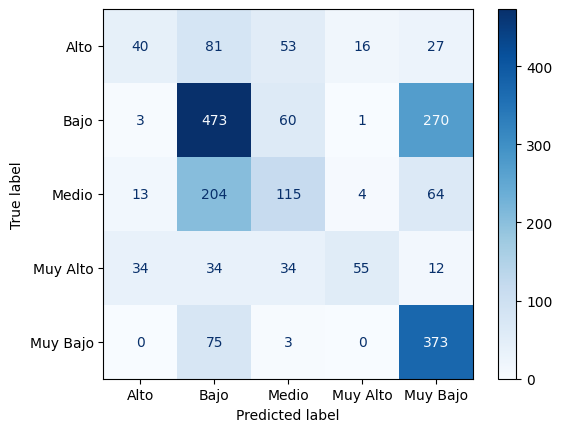

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Seleccionar el pipeline con la mejor exactitud (por ejemplo, el que obtuviste con Árboles de Decisión)
# Aquí asumimos que 'pipeline_with_transformer_dt' es el mejor. Si quieres cambiarlo por otro, simplemente reemplázalo.
best_pipeline = pipeline_with_transformer_dt

# Entrenar el modelo con los datos de entrenamiento
best_pipeline.fit(X_train, y_train)

# Predecir las etiquetas para el conjunto de validación
y_pred = best_pipeline.predict(X_test)

# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Mostrar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_pipeline.classes_)
disp.plot(cmap='Blues')


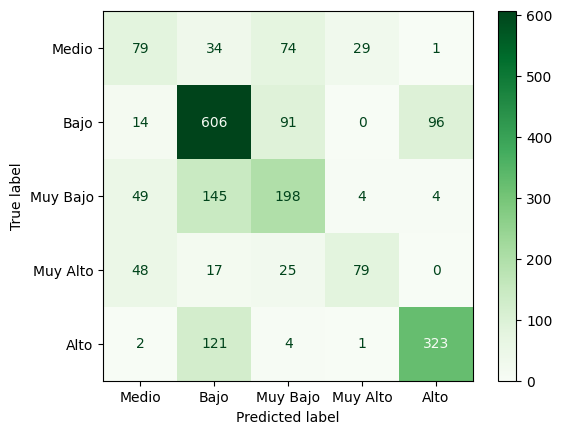

In [13]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay


#classifier = DecisionTreeClassifier(max_depth=8, random_state=42).fit(X_train, y_train)
class_names = y_test.unique()
disp = ConfusionMatrixDisplay.from_estimator(
      pipeline_with_transformer,
      X_test,
      y_test,
      display_labels=class_names,
      cmap=plt.cm.Greens
)


plt.show()

In [14]:
import pandas as pd
import numpy as np

df = pd.read_csv(url)
t1 = Transformador1()
X_train = t1.fit_transform(X_train)

rs = np.random.RandomState(0)

corr = X_train.corr()
corr.style.background_gradient(cmap='coolwarm')

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
longitude,1.000000,-0.924634,-0.106450,0.039876,0.064498,0.093946,0.051307,-0.016087
latitude,-0.924634,1.000000,0.010197,-0.032485,-0.063435,-0.104336,-0.067952,-0.078666
housing_median_age,-0.106450,0.010197,1.000000,-0.359712,-0.319423,-0.292964,-0.301625,-0.120034
total_rooms,0.039876,-0.032485,-0.359712,1.000000,0.929569,0.854261,0.917716,0.199610
total_bedrooms,0.064498,-0.063435,-0.319423,0.929569,1.000000,0.875414,0.979367,-0.007003
population,0.093946,-0.104336,-0.292964,0.854261,0.875414,1.000000,0.905296,0.004999
households,0.051307,-0.067952,-0.301625,0.917716,0.979367,0.905296,1.000000,0.013913
median_income,-0.016087,-0.078666,-0.120034,0.199610,-0.007003,0.004999,0.013913,1.000000


# Ejercicio 5

Siguiendo los mismos pasos crea un modelo de regresión que permita predecir el precio medio de la vivienda. Para ello tendrás que utilizar el dataset con la columna "median_house_value" en forma numérica. Puedes descargarlo otra vez. 

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer

# 1. Cargar el dataset
url = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv'
df = pd.read_csv(url)

# 2. Preparar los datos: eliminamos filas con valores nulos y utilizamos la columna 'median_house_value' en forma numérica
df = df.dropna(subset=['median_house_value'])

# 3. Dividir el dataset en características (X) y objetivo (y)
X = df.drop('median_house_value', axis=1)
y = df['median_house_value']

# Dividir los datos en conjunto de entrenamiento y validación (10% para validación)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# 4. Definir las columnas numéricas y categóricas
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# 5. Crear el preprocesador: imputar valores faltantes y realizar codificación de las columnas categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Imputar valores nulos con la media
            ('scaler', StandardScaler())  # Normalizar las características numéricas
        ]), numerical_cols),
        
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputar valores nulos con el valor más frecuente
            ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Codificar las variables categóricas
        ]), categorical_cols)
    ])

# 6. Crear el pipeline con un Árbol de Decisión para regresión
pipeline_regression = Pipeline([
    ('preprocessor', preprocessor),  # Preprocesamiento de los datos
    ('tree_reg', DecisionTreeRegressor(random_state=42))  # Árbol de Decisión para regresión
])

# 7. Evaluar el modelo utilizando validación cruzada
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline_regression, X_train, y_train, cv=k_fold, scoring='neg_mean_absolute_error')

# 8. Mostrar la métrica de rendimiento: MAE (Error Absoluto Medio)
print("MAE de validación cruzada (media):", -scores.mean())

# 9. Entrenar el modelo con los datos de entrenamiento
pipeline_regression.fit(X_train, y_train)

# 10. Realizar predicciones en el conjunto de validación
y_pred = pipeline_regression.predict(X_test)

# 11. Calcular y mostrar el Error Absoluto Medio (MAE) en el conjunto de validación
mae = mean_absolute_error(y_test, y_pred)
print(f"Error Absoluto Medio (MAE) en el conjunto de validación: {mae}")


C:\Users\Andrei\AppData\Roaming\Python\Python313\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


MAE de validación cruzada (media): 43790.81600450274
Error Absoluto Medio (MAE) en el conjunto de validación: 42347.90697674418
